Archivo descargado con éxito
Primeras filas del conjunto de datos:
   anio_inicio mes_inicio fecha_inicio hora_inicio  anio_hecho  mes_hecho  \
0         2024      Enero   2024-01-01    00:20:00      2024.0      Enero   
1         2024      Enero   2024-01-01    01:12:00      2023.0  Diciembre   
2         2024      Enero   2024-01-01    01:14:00      2023.0  Diciembre   
3         2024      Enero   2024-01-01    02:29:00      2023.0  Diciembre   
4         2024      Enero   2024-01-01    03:26:00      2024.0      Enero   

  fecha_hecho hora_hecho                                             delito  \
0  2024-01-01   00:20:00                PERDIDA DE LA VIDA POR OTRAS CAUSAS   
1  2023-12-28   21:45:00  HOMICIDIO CULPOSO POR TRÃNSITO VEHICULAR (COL...   
2  2023-12-31   23:00:00                       PERDIDA DE LA VIDA POR CAIDA   
3  2023-12-31   23:50:00  ROBO EN EVENTOS MASIVOS (DEPORTIVOS, CULTURALE...   
4  2024-01-01   02:10:00               PERDIDA DE LA VIDA POR PARO CARDIACO

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
gbc,Gradient Boosting Classifier,0.8715,0.0000,0.8715,0.7972,0.8183,0.0701,0.1478,46.8720
ridge,Ridge Classifier,0.8725,0.0000,0.8725,0.7799,0.8166,0.0535,0.1481,0.2960
lda,Linear Discriminant Analysis,0.8566,0.0000,0.8566,0.7868,0.8131,0.0874,0.1161,0.3720
lr,Logistic Regression,0.8694,0.0000,0.8694,0.7559,0.8087,0.0000,0.0000,16.1270
dummy,Dummy Classifier,0.8694,0.2500,0.8694,0.7559,0.8087,0.0000,0.0000,0.2280
knn,K Neighbors Classifier,0.8668,0.2724,0.8668,0.7671,0.8082,0.0038,0.0119,2.6170
rf,Random Forest Classifier,0.8341,0.2938,0.8341,0.7763,0.8024,0.0673,0.0741,3.7500
et,Extra Trees Classifier,0.8339,0.2798,0.8339,0.7758,0.8022,0.0674,0.0741,4.6380
ada,Ada Boost Classifier,0.8310,0.0000,0.8310,0.7898,0.7991,0.0487,0.0576,2.4460
lightgbm,Light Gradient Boosting Machine,0.8289,0.2790,0.8289,0.7752,0.7985,0.0524,0.0580,5.1660



Graficando el rendimiento del mejor modelo:


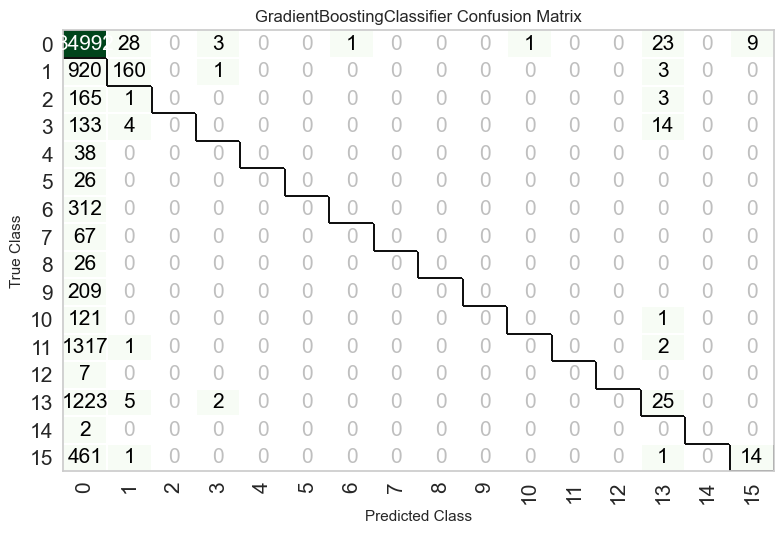

In [1]:
# region IMPORTACIÓN DE LIBRERÍAS 
import os
import warnings
import logging

# Desactivar oneDNN para reducir mensajes innecesarios de TensorFlow
os.environ["TF_ENABLE_ONEDNN_OPTS"] = "0"
warnings.filterwarnings('ignore')  # Ignorar todas las advertencias

# Establecer el nivel de logging en CRITICAL para evitar mensajes innecesarios
logging.basicConfig(level=logging.CRITICAL)

import time
import requests
from io import StringIO
import pandas as pd
import tensorflow as tf
from pycaret.classification import *  # Asegúrate de que estamos importando desde pycaret.classification
import matplotlib.pyplot as plt
#endregion

# region URL del archivo CSV
url = 'https://archivo.datos.cdmx.gob.mx/FGJ/carpetas/carpetasFGJ_2024.csv'
#endregion

# region Descargar archivo con reintentos
for i in range(3):  # Intentar 3 veces
    try:
        response = requests.get(url, timeout=10)
        response.raise_for_status()
        df = pd.read_csv(StringIO(response.text))
        print("Archivo descargado con éxito")
        break
    except requests.exceptions.RequestException as e:
        print(f"Intento {i+1} fallido: {e}")
else:
    print("Error: No se pudo descargar el archivo después de varios intentos")
    exit()
#endregion

# region Visualización inicial
print("Primeras filas del conjunto de datos:")
print(df.head())
print("\nInformación del conjunto de datos:")
print(df.info())
print("\nDescripción estadística de los datos numéricos:")
print(df.describe())
#endregion

# region Manejo de valores nulos con promedios según categoría
print("\nValores nulos por columna antes de la limpieza:")
print(df.isnull().sum())

# Rellenar valores nulos en columnas numéricas (latitud, longitud) con el promedio por categoria_delito
df['latitud'] = df.groupby('categoria_delito')['latitud'].transform(lambda x: x.fillna(x.mean()))
df['longitud'] = df.groupby('categoria_delito')['longitud'].transform(lambda x: x.fillna(x.mean()))

# Rellenar otros valores faltantes con opciones relevantes
df['colonia_hecho'].fillna('desconocido', inplace=True)
df['alcaldia_hecho'].fillna('desconocido', inplace=True)
df['municipio_hecho'].fillna('desconocido', inplace=True)

# Para columnas de tiempo, asignar "00:00:00" en valores nulos
df['hora_inicio'].fillna("00:00:00", inplace=True)
df['hora_hecho'].fillna("00:00:00", inplace=True)

# Para columna de año y mes, rellenar con valores más frecuentes
df['anio_hecho'].fillna(df['anio_hecho'].mode()[0], inplace=True)
df['mes_hecho'].fillna(df['mes_hecho'].mode()[0], inplace=True)
df['fecha_hecho'].fillna(method='ffill', inplace=True)  # Usar 'ffill' para rellenar fechas consecutivas
#endregion

# region Seleccionar columnas de interés
columns_of_interest = ['mes_hecho', 'anio_hecho', 'fecha_hecho', 'hora_hecho', 
                       'categoria_delito', 'alcaldia_hecho', 
                       'colonia_hecho', 'municipio_hecho']
df = df[columns_of_interest]
#endregion

# region Revisar y convertir tipos de datos
df['fecha_hecho'] = pd.to_datetime(df['fecha_hecho'], errors='coerce')
df['categoria_delito'] = df['categoria_delito'].astype('category')
df['alcaldia_hecho'] = df['alcaldia_hecho'].astype('category')
#endregion

# region Normalización y Filtrado
# Convertir texto a minúsculas y eliminar espacios en blanco adicionales
df['categoria_delito'] = df['categoria_delito'].str.lower().str.strip()
df['alcaldia_hecho'] = df['alcaldia_hecho'].str.lower().str.strip()
df['colonia_hecho'] = df['colonia_hecho'].str.lower().str.strip()
df['municipio_hecho'] = df['municipio_hecho'].str.lower().str.strip()
#endregion

# region Eliminar duplicados
df.drop_duplicates(inplace=True)
#endregion

# region Mostrar resumen de columnas clave y valores nulos
print("\nResumen de columnas clave y valores nulos:")
print(df.info())
print("\nValores nulos restantes en las columnas clave después de la limpieza:")
print(df.isnull().sum())

# Mostrar la cantidad de datos en la base de datos limpia (solo las columnas de interés)
rows, columns = df.shape
print(f"\nCantidad de datos en la base de datos limpia (solo columnas de interés): {rows} filas y {columns} columnas.")
#endregion

# region Conteo de tipos de delito
print("\nConteo de tipos de delito en 'categoria_delito':")
delito_counts = df['categoria_delito'].value_counts()
print(delito_counts)
#endregion

# region Configuración de clasificación con PyCaret
# Seleccionar solo las columnas necesarias para la clasificación
data_c = df[['fecha_hecho', 'hora_hecho', 'categoria_delito', 'alcaldia_hecho']].copy()

# Combinar 'fecha_hecho' con 'hora_hecho' en una sola columna y convertirla en datetime
data_c['fecha_hecho'] = data_c['fecha_hecho'].astype(str).str.cat(data_c['hora_hecho'].astype(str), sep=',')
data_c.drop(['hora_hecho'], axis=1, inplace=True)
data_c['fecha_hecho'] = pd.to_datetime(data_c['fecha_hecho'], format='%Y-%m-%d,%H:%M:%S', errors='coerce')

# Crear columnas adicionales para día, mes, año y hora
data_c['day'] = data_c['fecha_hecho'].dt.day
data_c['month'] = data_c['fecha_hecho'].dt.month
data_c['year'] = data_c['fecha_hecho'].dt.year
data_c['hour'] = data_c['fecha_hecho'].dt.hour

# Asegurarse de que no hay valores nulos en las columnas críticas para PyCaret
data_c.dropna(subset=['fecha_hecho', 'categoria_delito', 'alcaldia_hecho'], inplace=True)

# Configuración de PyCaret para la tarea de clasificación
print("\nConfiguración de PyCaret para clasificación:")
s_c = setup(data=data_c, 
            target='categoria_delito',  # Cambiar a 'categoria_delito' en lugar de 'delito'
            session_id=123,  # Para reproducibilidad
            verbose=False)  # Sin salida detallada en la consola

# Comparar modelos de clasificación y seleccionar el mejor según F1-score
print("\nComparando modelos...")
best_c = compare_models(sort='F1')

# Visualizar rendimiento del modelo seleccionado en el conjunto de validación (holdout)
print("\nGraficando el rendimiento del mejor modelo:")
plot_model(best_c, plot='confusion_matrix')


Optimizando hiperparámetros del mejor modelo:


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.8730,0.0000,0.8730,0.8025,0.8183,0.0655,0.1623
1,0.8721,0.0000,0.8721,0.7939,0.8157,0.0460,0.1400
2,0.8727,0.0000,0.8727,0.8013,0.8173,0.0575,0.1539
3,0.8717,0.0000,0.8717,0.8011,0.8149,0.0409,0.1294
4,0.8735,0.0000,0.8735,0.7944,0.8194,0.0724,0.1715
5,0.8732,0.0000,0.8732,0.7950,0.8182,0.0632,0.1631
6,0.8715,0.0000,0.8715,0.7779,0.8153,0.0456,0.1268
7,0.8726,0.0000,0.8726,0.7952,0.8168,0.0547,0.1492
8,0.8713,0.0000,0.8713,0.7821,0.8149,0.0421,0.1209


Fitting 10 folds for each of 10 candidates, totalling 100 fits
Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).

Graficando el rendimiento del modelo optimizado:


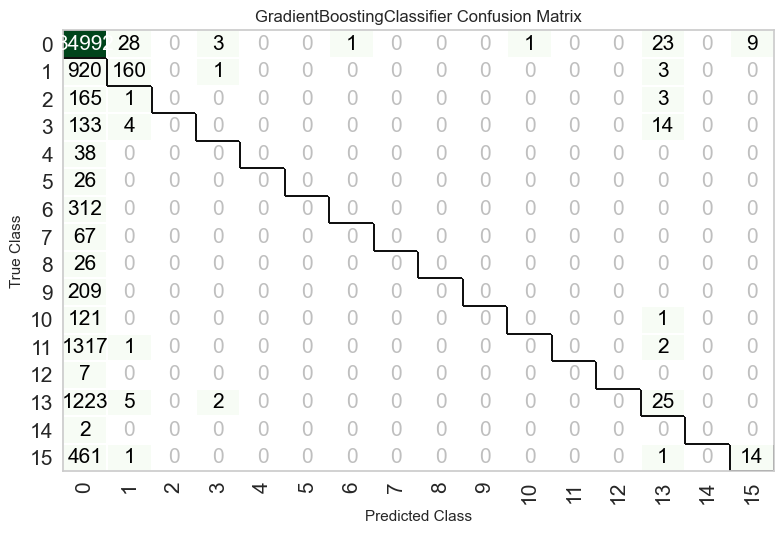


Predicciones del modelo en el conjunto de retención:


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Gradient Boosting Classifier,0.8727,0.6601,0.8727,0.7997,0.8190,0.0706,0.1609


              fecha_hecho         alcaldia_hecho  day  month  year  hour  \
5732  2023-12-17 19:30:00         alvaro obregon   17     12  2023    19   
28653 2024-02-16 19:45:00  cuajimalpa de morelos   16      2  2024    19   
63695 2024-04-08 13:30:00             milpa alta    8      4  2024    13   
85559 2024-05-12 02:20:00          benito juarez   12      5  2024     2   
1657  2023-12-27 11:30:00             iztapalapa   27     12  2023    11   

             categoria_delito        prediction_label  prediction_score  
5732   delito de bajo impacto  delito de bajo impacto            0.9189  
28653  delito de bajo impacto  delito de bajo impacto            0.9237  
63695  delito de bajo impacto  delito de bajo impacto            0.9126  
85559  delito de bajo impacto  delito de bajo impacto            0.9205  
1657   delito de bajo impacto  delito de bajo impacto            0.9398  


In [2]:
# Optimización de hiperparámetros del mejor modelo
print("\nOptimizando hiperparámetros del mejor modelo:")
best_c_tuned = tune_model(best_c, optimize='F1')

# Visualizar rendimiento del modelo optimizado
print("\nGraficando el rendimiento del modelo optimizado:")
plot_model(best_c_tuned, plot='confusion_matrix')

# Evaluación final del modelo con predicciones en el conjunto de retención
print("\nPredicciones del modelo en el conjunto de retención:")
predictions = predict_model(best_c_tuned)
print(predictions.head())

In [3]:
# Guardar el modelo
save_model(best_c_tuned, 'modelo_criminalidad')

# Cargar el modelo
modelo = load_model('modelo_criminalidad')

Transformation Pipeline and Model Successfully Saved
Transformation Pipeline and Model Successfully Loaded


In [28]:
# region URL del archivo CSV para datos de prueba 2023
url_test = 'https://archivo.datos.cdmx.gob.mx/FGJ/carpetas/carpetasFGJ_2023.csv'
#endregion

# region Descargar archivo con reintentos para 2023
for i in range(3):  # Intentar 3 veces
    try:
        response = requests.get(url_test, timeout=10)
        response.raise_for_status()
        df_test = pd.read_csv(StringIO(response.text))
        print("Archivo de prueba 2023 descargado con éxito")
        break
    except requests.exceptions.RequestException as e:
        print(f"Intento {i+1} fallido: {e}")
else:
    print("Error: No se pudo descargar el archivo después de varios intentos")
    exit()
#endregion

# region Visualización inicial para 2023
print("Primeras filas del conjunto de datos de prueba:")
print(df_test.head())
print("\nInformación del conjunto de datos de prueba:")
print(df_test.info())
print("\nDescripción estadística de los datos numéricos de prueba:")
print(df_test.describe())
#endregion

# region Manejo de valores nulos con promedios según categoría
print("\nValores nulos por columna antes de la limpieza:")
print(df_test.isnull().sum())

# Rellenar valores nulos en columnas numéricas (latitud, longitud) con el promedio por categoria_delito
df_test['latitud'] = df_test.groupby('categoria_delito')['latitud'].transform(lambda x: x.fillna(x.mean()))
df_test['longitud'] = df_test.groupby('categoria_delito')['longitud'].transform(lambda x: x.fillna(x.mean()))

# Rellenar otros valores faltantes con opciones relevantes
df_test['colonia_hecho'].fillna('desconocido', inplace=True)
df_test['alcaldia_hecho'].fillna('desconocido', inplace=True)
df_test['municipio_hecho'].fillna('desconocido', inplace=True)

# Para columnas de tiempo, asignar "00:00:00" en valores nulos
df_test['hora_inicio'].fillna("00:00:00", inplace=True)
df_test['hora_hecho'].fillna("00:00:00", inplace=True)

# Para columna de año y mes, rellenar con valores más frecuentes
df_test['anio_hecho'].fillna(df_test['anio_hecho'].mode()[0], inplace=True)
df_test['mes_hecho'].fillna(df_test['mes_hecho'].mode()[0], inplace=True)
df_test['fecha_hecho'].fillna(method='ffill', inplace=True)  # Usar 'ffill' para rellenar fechas consecutivas
#endregion

# region Seleccionar columnas de interés para 2023
columns_of_interest_test = ['mes_hecho', 'anio_hecho', 'fecha_hecho', 'hora_hecho', 
                            'categoria_delito', 'alcaldia_hecho', 
                            'colonia_hecho', 'municipio_hecho']
df_test = df_test[columns_of_interest_test]
#endregion

# region Revisar y convertir tipos de datos para 2023
df_test['fecha_hecho'] = pd.to_datetime(df_test['fecha_hecho'], errors='coerce')
df_test['categoria_delito'] = df_test['categoria_delito'].astype('category')
df_test['alcaldia_hecho'] = df_test['alcaldia_hecho'].astype('category')
#endregion

# region Normalización y Filtrado para 2023
# Convertir texto a minúsculas y eliminar espacios en blanco adicionales
df_test['categoria_delito'] = df_test['categoria_delito'].str.lower().str.strip()
df_test['alcaldia_hecho'] = df_test['alcaldia_hecho'].str.lower().str.strip()
df_test['colonia_hecho'] = df_test['colonia_hecho'].str.lower().str.strip()
df_test['municipio_hecho'] = df_test['municipio_hecho'].str.lower().str.strip()
#endregion

# region Eliminar duplicados en 2023
df_test.drop_duplicates(inplace=True)
#endregion

# region Mostrar resumen de columnas clave y valores nulos para 2023
print("\nResumen de columnas clave y valores nulos:")
print(df_test.info())
print("\nValores nulos restantes en las columnas clave después de la limpieza:")
print(df_test.isnull().sum())

# Mostrar la cantidad de datos en la base de datos limpia (solo las columnas de interés)
rows_test, columns_test = df_test.shape
print(f"\nCantidad de datos en la base de datos limpia (solo columnas de interés): {rows_test} filas y {columns_test} columnas.")
#endregion

# region Conteo de tipos de delito para 2023
print("\nConteo de tipos de delito en 'categoria_delito':")
delito_counts_test = df_test['categoria_delito'].value_counts()
print(delito_counts_test)
#endregion

# region Configuración de clasificación con PyCaret para datos de prueba 2023
# Seleccionar solo las columnas necesarias para la clasificación
data_test_c = df_test[['fecha_hecho', 'hora_hecho', 'categoria_delito', 'alcaldia_hecho']].copy()

# Combinar 'fecha_hecho' con 'hora_hecho' en una sola columna y convertirla en datetime
data_test_c['fecha_hecho'] = data_test_c['fecha_hecho'].astype(str).str.cat(data_test_c['hora_hecho'].astype(str), sep=',')
data_test_c.drop(['hora_hecho'], axis=1, inplace=True)
data_test_c['fecha_hecho'] = pd.to_datetime(data_test_c['fecha_hecho'], format='%Y-%m-%d,%H:%M:%S', errors='coerce')

# Crear columnas adicionales para día, mes, año y hora
data_test_c['day'] = data_test_c['fecha_hecho'].dt.day
data_test_c['month'] = data_test_c['fecha_hecho'].dt.month
data_test_c['year'] = data_test_c['fecha_hecho'].dt.year
data_test_c['hour'] = data_test_c['fecha_hecho'].dt.hour

# Asegurarse de que no hay valores nulos en las columnas críticas para PyCaret
data_test_c.dropna(subset=['fecha_hecho', 'categoria_delito', 'alcaldia_hecho'], inplace=True)

# Configuración de PyCaret para la tarea de clasificación




Archivo de prueba 2023 descargado con éxito
Primeras filas del conjunto de datos de prueba:
   anio_inicio mes_inicio fecha_inicio hora_inicio  anio_hecho  mes_hecho  \
0         2023      Enero   2023-01-01    00:09:45      2022.0  Diciembre   
1         2023      Enero   2023-01-01    00:41:26      2022.0  Diciembre   
2         2023      Enero   2023-01-01    00:44:43      2022.0  Diciembre   
3         2023      Enero   2023-01-01    00:47:23      2022.0  Diciembre   
4         2023      Enero   2023-01-01    00:56:35      2022.0  Diciembre   

  fecha_hecho hora_hecho                                             delito  \
0  2022-12-31   22:08:00  LESIONES CULPOSAS POR TRANSITO VEHICULAR EN CO...   
1  2022-12-31   23:50:00     ROBO A TRANSEUNTE EN VIA PUBLICA CON VIOLENCIA   
2  2022-12-31   20:30:00  ROBO DE VEHICULO DE SERVICIO PARTICULAR CON VI...   
3  2022-12-31   23:30:00  LESIONES CULPOSAS POR TRANSITO VEHICULAR EN CO...   
4  2022-12-31   10:30:00                PERDIDA DE

In [36]:
data_test_c

,fecha_hecho,categoria_delito,alcaldia_hecho,day,month,year,hour
0,2022-12-31 22:08:00,delito de bajo impacto,coyoacan,31,12,2022,22
1,2022-12-31 23:50:00,robo a transeunte en vãa pãblica con y sin v...,venustiano carranza,31,12,2022,23
2,2022-12-31 20:30:00,robo de vehãculo con y sin violencia,gustavo a. madero,31,12,2022,20
3,2022-12-31 23:30:00,delito de bajo impacto,coyoacan,31,12,2022,23
4,2022-12-31 10:30:00,hecho no delictivo,gustavo a. madero,31,12,2022,10
...,...,...,...,...,...,...,...
242387,2017-12-28 12:00:00,violaciãn,cuauhtemoc,28,12,2017,12
242388,2023-06-22 13:00:00,homicidio doloso,azcapotzalco,22,6,2023,13
242389,2023-07-30 22:15:00,homicidio doloso,cdmx (indeterminada),30,7,2023,22
242390,2023-10-03 15:10:00,delito de bajo impacto,iztapalapa,3,10,2023,15


In [38]:
data_test=data_test_c.drop("categoria_delito",axis=1)
final_model=finalize_model(best_c_tuned)
predictions=predict_model(final_model,data_test_c)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Gradient Boosting Classifier,0.8707,0.6542,0.8707,0.8353,0.8136,0.0388,0.1202


In [44]:
predictions

,fecha_hecho,alcaldia_hecho,day,month,year,hour,categoria_delito,prediction_label,prediction_score
0,2022-12-31 22:08:00,coyoacan,31,12,2022,22,delito de bajo impacto,delito de bajo impacto,0.8577
1,2022-12-31 23:50:00,venustiano carranza,31,12,2022,23,robo a transeunte en vãa pãblica con y sin v...,delito de bajo impacto,0.8517
2,2022-12-31 20:30:00,gustavo a. madero,31,12,2022,20,robo de vehãculo con y sin violencia,delito de bajo impacto,0.8496
3,2022-12-31 23:30:00,coyoacan,31,12,2022,23,delito de bajo impacto,delito de bajo impacto,0.8639
4,2022-12-31 10:30:00,gustavo a. madero,31,12,2022,10,hecho no delictivo,delito de bajo impacto,0.9445
...,...,...,...,...,...,...,...,...,...
242387,2017-12-28 12:00:00,cuauhtemoc,28,12,2017,12,violaciãn,delito de bajo impacto,0.9530
242388,2023-06-22 13:00:00,azcapotzalco,22,6,2023,13,homicidio doloso,delito de bajo impacto,0.8876
242389,2023-07-30 22:15:00,cdmx (indeterminada),30,7,2023,22,homicidio doloso,delito de bajo impacto,0.7492
242390,2023-10-03 15:10:00,iztapalapa,3,10,2023,15,delito de bajo impacto,delito de bajo impacto,0.8243


In [46]:
actual=data_test_c["categoria_delito"]
comparison_df=pd.DataFrame({"acual":actual,"predicted":predictions["prediction_label"]})
print(comparison_df.head())

                                               acual               predicted
0                             delito de bajo impacto  delito de bajo impacto
1  robo a transeunte en vãa pãblica con y sin v...  delito de bajo impacto
2              robo de vehãculo con y sin violencia  delito de bajo impacto
3                             delito de bajo impacto  delito de bajo impacto
4                                 hecho no delictivo  delito de bajo impacto


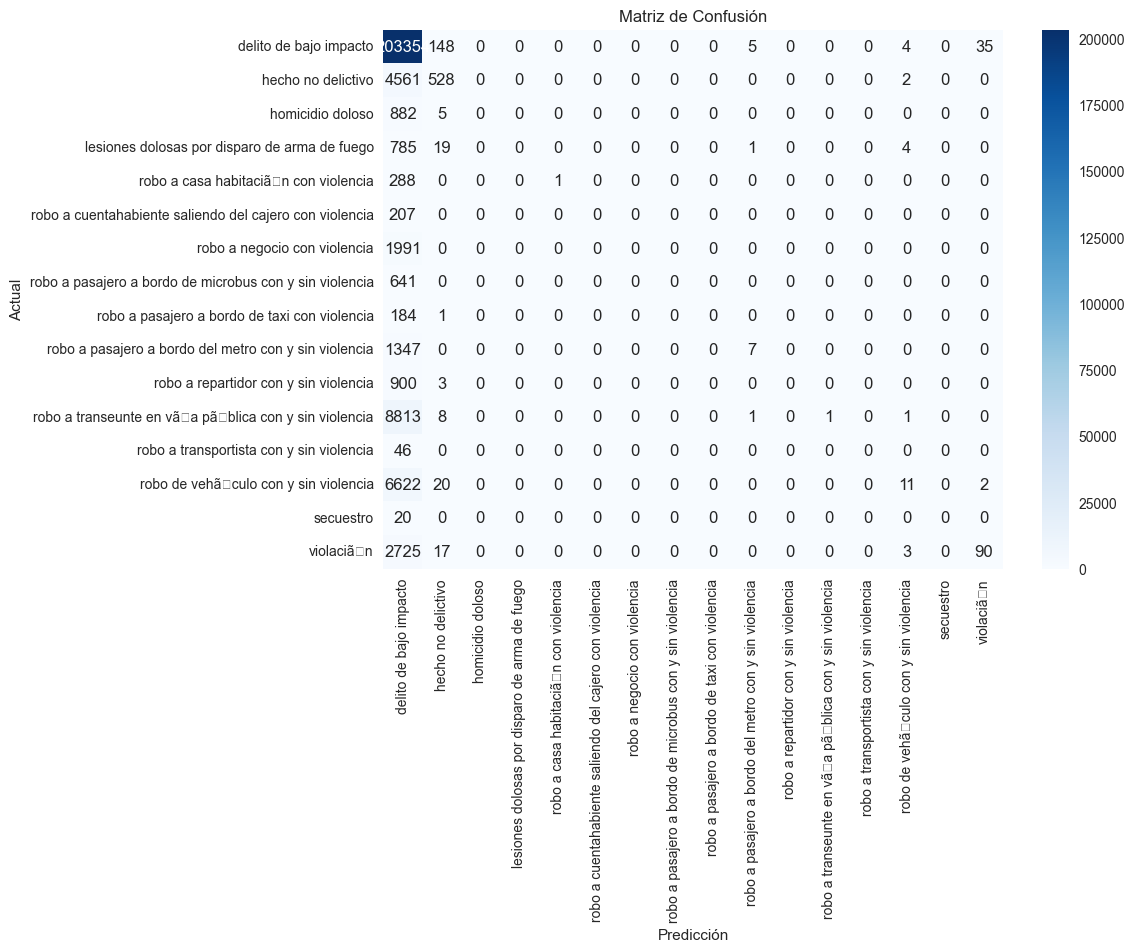

In [49]:



import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Calcula la matriz de confusión
actual = comparison_df["acual"]
predicted = comparison_df["predicted"]
conf_matrix = confusion_matrix(actual, predicted)

# Crea un heatmap para la matriz de confusión
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", 
            xticklabels=sorted(actual.unique()), 
            yticklabels=sorted(actual.unique()))

# Etiquetas y título
plt.xlabel("Predicción")
plt.ylabel("Actual")
plt.title("Matriz de Confusión")
plt.show()